In [20]:
import torch
import sys
import re
import torch.nn as nn
# from torch.nn import TransformerDecoder, TransformerDecoderLayer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    file_path = './kaggleData/data/eng-cmn.txt'
else:
    file_path = '/kaggle/input/eng-cmn/eng-cmn.txt'
    sys.path.append('/kaggle/input/eng-cmn')


text_pairs = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:

        parts = line.strip().split('\t')
        

        if len(parts) < 3:
            continue
            
        en_text = parts[0].strip()
        zh_text = parts[1].strip()
        

        if en_text and zh_text:

            text_pairs.append((zh_text, en_text))

def split_chinese_english(s):

    pattern = re.compile(r'([\u4e00-\u9fff]+)|([^\u4e00-\u9fff]+)')
    result = []
    for block in pattern.findall(s):
        chinese_part, non_chinese_part = block
        if chinese_part:
            
            result.extend(list(chinese_part))
        elif non_chinese_part:

            subparts = non_chinese_part.lower().split()
            for sub in subparts:

                processed = re.sub(r'[^a-zA-Z]', '', sub)
                if processed:
                    result.append(processed)
    return result
    


In [21]:
from collections import defaultdict

def build_vocab(text_pairs, unknown = True):
    '''
    text_pairs: raw cn-eng text pair
    unknown: whether to deal with unkonwn words
    '''
    vocab = defaultdict(lambda: len(vocab))
    special_tokens = ["<pad>", "<sos>", "<eos>", "<sep>"]
    for token in special_tokens:
        vocab[token]

    for ch, en in text_pairs:
        ch = split_chinese_english(ch)
        for char in ch:
            vocab[char]
        en = split_chinese_english(en)
        for char in en:
            vocab[char]
    # add <unk> to the las of the vocab to deal with unknown words
    if unknown:    
        vocab['<unk>']
    
    # freeze vocab (check usage of 'defaultdict')
    vocab.default_factory = None
    
    return vocab

def text_to_ids(text, vocab):
    unk_id = vocab['<unk>']
    split = split_chinese_english(text)
    # print(split)
    ids = [vocab.get(id, unk_id) for id in split]
    return ids

In [ ]:
# build vocab
vocab = build_vocab(text_pairs)
len(vocab)

In [93]:
# build dataset

from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, pairs, vocab, max_len=50, pad = True):
        self.pairs = pairs
        self.vocab = vocab
        self.max_len = max_len
        self.pad = pad

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ch, en = self.pairs[idx]

        input_ids_cn_eng = (
            [self.vocab["<sos>"]] +
            text_to_ids(ch, self.vocab) +
            [self.vocab["<sep>"]] +
            text_to_ids(en, self.vocab) +
            [self.vocab["<eos>"]]
        )

        input_ids_cn_eng = input_ids_cn_eng[:self.max_len]
        src = input_ids_cn_eng[:-1]
        tgt = input_ids_cn_eng[1:]

        if self.pad:
            # pad to max_len
            # ================================================================
            src += [self.vocab["<pad>"]]* (self.max_len - len(src))
            tgt += [self.vocab["<pad>"]]* (self.max_len - len(tgt))
            # ================================================================

        return torch.tensor(src), torch.tensor(tgt)

In [24]:
# hyper params

vocab_size = len(vocab)
eval_num = 100
BATCH_SIZE = 32
MAX_LEN = 49
model_max_seq=128
max_epoch = 80
num_heads = 2

dataset = TranslationDataset(text_pairs, vocab, model_max_seq)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
# define a real gpt:
from BuildingBlocks import MultiHeadAttention

# gpt config:
GPT_CONFIG_124M = {
"vocab_size": len(vocab), # Vocabulary size
"context_length": 128, # Context length: max sequence length the model can handle 
"emb_dim": 64, # Embedding dimension
"n_heads": 4, # Number of attention heads
"n_layers": 4, # Number of layers
"drop_rate": 0.0, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        # unbiased=False: divided by n instead of n-1
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 *torch.pow(x, 3))
        ))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            # (2, 3, 768)->(2, 3, 3072)
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            # (2,3,3072) -> (2,3,3072)
            GELU(),
            # (2,3,3072)->(2,3,768)
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
    
# GPT DEF
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
# initialize model and start training

# model = SimpleGPTTranslator(vocab_size=vocab_size).to(device)
model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index = -100)
ignore_index = [0] # ignore <pad>

max_epoch = 80
# training loop cn-eng:
for epoch in range(max_epoch):
    total_loss = 0
    for src, tgt in dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        # print(tgt)
        msk = torch.isin(tgt, torch.tensor(ignore_index).to(device))
        tgt[msk] = -100
        # print(tgt)
        # print(src.shape)
        optimizer.zero_grad()
        # print(src)
        output = model(src)
        # print(output.shape)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

# # training loop reverse: eng-cn
# for epoch in range(max_epoch):
#     total_loss = 0
#     for src, tgt in dataloaderreverse:
#         src = src.to(device)
#         tgt = tgt.to(device)
#         # print(tgt)
#         msk = torch.isin(tgt, torch.tensor(ignore_index).to(device))
#         tgt[msk] = -100
#         # print(tgt)
#         # print(src.shape)
#         optimizer.zero_grad()
#         # print(src)
#         output = model(src)
#         # print(output.shape)
#         loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

# save model
torch.save(model.state_dict(), "gpt2_rev_weights.pth")

In [37]:
# reload model
# model = SimpleGPTTranslator(vocab_size=vocab_size).to(device)
model = GPTModel(GPT_CONFIG_124M).to(device)
model.load_state_dict(torch.load('gpt2_rev_weights.pth', map_location=device))
# model.load_state_dict(torch.load('gpt2_weights.pth', map_location=device))


<All keys matched successfully>

In [38]:
# translate chinese to english
def translate_cn_eng(model, ch_text, vocab, max_len=80):
    model.to(device)
    model.eval()

    input_ids = (
        [vocab["<sos>"]] +
        text_to_ids(ch_text, vocab) +
        [vocab["<sep>"]]
    )
    input_tensor = torch.tensor([input_ids], device=device)


    for _ in range(max_len):
        if len(input_ids) >50:
            # print('max length hit')
            break
        output = model(input_tensor)

        # extract the last words of output as the predicted words
        # [0, -1]: 0 for batch, since we only have 1 data per batch
        next_token = output[0, -1].argmax().item()
        # print(next_token)
        input_ids.append(next_token)
        if next_token == vocab["<eos>"]:
            print('predict ends')
            break
        

        input_tensor = torch.tensor([input_ids], device=device)
    

    sep_pos = input_ids.index(vocab["<sep>"])
    en_ids = input_ids[sep_pos+1:-1]
    

    id_to_token = {v: k for k, v in vocab.items()}
    return " ".join([id_to_token[id] for id in en_ids])


# translate english to chinese (deprecated)
def translate_eng_cn(model, eng_text, vocab, max_len=80):
    model.to(device)
    model.eval()

    input_ids = (
        [vocab["<sos>"]] +
        text_to_ids(eng_text, vocab) +
        [vocab["<sep>"]]
    )
    input_tensor = torch.tensor([input_ids], device=device)
    # print(input_tensor.device)
    # input_tensor = input_tensor.to(device)
    

    for _ in range(max_len):
        if len(input_ids) >50:
            # print('max length hit')
            break
        output = model(input_tensor)

        # extract the last words of output as the predicted words
        # [0, -1]: 0 for batch, since we only have 1 data per batch
        next_token = output[0, -1].argmax().item()
        # print(next_token)
        input_ids.append(next_token)
        if next_token == vocab["<eos>"]:
            print('predict ends')
            break
        

        input_tensor = torch.tensor([input_ids], device=device)
    

    sep_pos = input_ids.index(vocab["<sep>"])
    ch_ids = input_ids[sep_pos+1:-1]
    

    id_to_token = {v: k for k, v in vocab.items()}
    return "".join([id_to_token[id] for id in ch_ids])



In [94]:
model.eval()
def decode(id_to_token, ids):
    input_tokens = [id_to_token[id] for id in ids.squeeze(0).tolist()]
    return input_tokens

id_to_token = {v: k for k, v in vocab.items()}
dataset_eval = TranslationDataset(text_pairs, vocab, model_max_seq, pad = False)
dataloader_eval = DataLoader(dataset_eval, batch_size=1, shuffle=True)

In [109]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # use system chinese font
plt.rcParams['axes.unicode_minus'] = False    

def visualize_attention_heatmap(attention_weights, layer_idx, head_idx, input_tokens=None):
    """
    params
        attention_weights (list): list of attentions weights maxtrix of all layers, elements shape: (b, num_heads, seq_len, seq_len): tensor
        layer_idx (int): layer index: int, GPT_CONFIG_124M['n_layers']
        head_idx (int): head index: int, GPT_CONFIG_124M['n_heads']
        input_tokens (list): optional, list of words
    """

    attn_matrix = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
    seq_len = attn_matrix.shape[0]

    # create heat map
    plt.figure(figsize=(6, 5))
    plt.imshow(attn_matrix, cmap='plasma', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.title(f'Layer {layer_idx} Head {head_idx} Attention Heatmap')
    plt.xlabel('Source Positions (j)')
    plt.ylabel('Target Positions (i)')

    if input_tokens is not None:
        plt.xticks(range(seq_len), input_tokens, rotation=45)
        plt.yticks(range(seq_len), input_tokens)
    else:
        plt.xticks(range(seq_len))
        plt.yticks(range(seq_len))

    plt.tight_layout()
    plt.savefig(f'attn-layer{layer_idx}-head{head_idx}.png')
    plt.show()

In [ ]:
# input a sequence to model to get attention weights for the input
src, tgt = next(iter(dataloader_eval))
input_tokens = decode(id_to_token, src)
_ = model(src)
attention_weights = [model.trf_blocks[layer].att.attentions for layer in range(GPT_CONFIG_124M['n_layers'])]

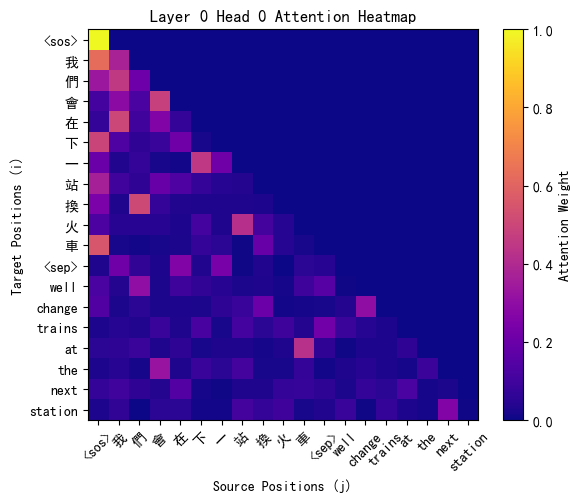

In [110]:
visualize_attention_heatmap(attention_weights, layer_idx=0, head_idx=0, input_tokens=input_tokens)

In [108]:
# eval
# chinese to english
import numpy as np
for i in np.random.randint(0, len(text_pairs), eval_num):
    cn = text_pairs[i][0]
    en = text_pairs[i][1]
    print(f'> {cn}')
    print(f'= {en}')
    print(f'< {translate_cn_eng(model, cn, vocab)}')
    print('='*20)


> 太阳从东边升起，西边落下。
= The sun comes up in the east and goes down in the west.
predict ends
< the sun rises in the east and sets in the west
> 用英语说。
= Say it in English.
predict ends
< make a languages
> 你应该一直让手保持干净。
= You must always keep your hands clean.
predict ends
< you must always keep your hands clean
> 幾點了？
= What time is it?
predict ends
< what time is it
> 我只要自由。
= All I want is my freedom.
predict ends
< i just need more
> 我們只是需要確認Tom有要來這。
= We just have to make sure Tom is planning to be here.
predict ends
< we just need to be sure that tom wants this
> 我們以前討論過。
= We've had this discussion before.
predict ends
< we have trouble recently
> 你做了什么？
= What did you do?
predict ends
< what did you do
> 你們倆都錯了。
= Both of you are wrong.
predict ends
< both of their ones
> 抓住汤姆。
= Grab Tom.
predict ends
< grab tom
> 湯姆有了個好辦法。
= Tom has come up with a good plan.
predict ends
< tom has a good trouble nice trip
> 你聽從她的忠告是明智的。
= It was sensible of you to follow her advice.
predict ends
< yo